In [27]:
import numpy as np
from mec_sandia.stopping_power import compute_stopping_power
import matplotlib.pyplot as plt

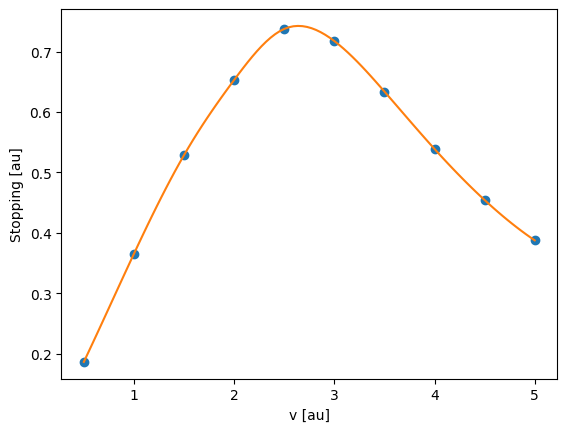

In [28]:
# Get DFT data
qData1 = np.loadtxt("AndrewsFirstGaussian/4.0_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / 4.0
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

# load the full stopping curve
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    0.529 / 27.2
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha
plt.plot(velocity_au, stopping_au, marker="o", lw=0)
plt.xlabel("v [au]")
plt.ylabel("Stopping [au]")
from scipy.interpolate import CubicSpline

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
plt.plot(xs, stopping_spl(xs), label="cubic spline")

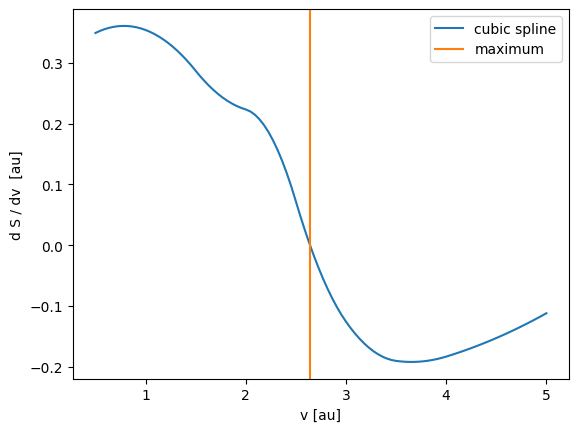

In [29]:
stopping_deriv_spl = stopping_spl.derivative(1)
import scipy.optimize

max_vel = scipy.optimize.bisect(stopping_deriv_spl, velocity_au[0], velocity_au[-1])
plt.plot(xs, stopping_deriv_spl(xs), label="cubic spline")
plt.xlabel("v [au]")
plt.axvline(max_vel, label="maximum", color="C1")
plt.ylabel("d S / dv  [au]")
plt.legend()

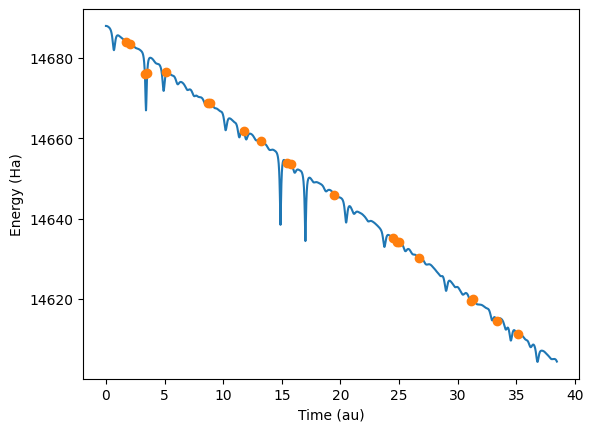

In [30]:
# Look at a single velocity first
v_proj = 4.0  # atomic units just taken from carbon
mass_proj = 1836
ke_proj = 0.5 * mass_proj * v_proj**2.0  # classical ke
ke_time = 0.5 * mass_proj * (v_proj**2) - work_au
velocity_time = np.sqrt(2.0 / mass_proj * ke_time)  # 1/2 mv^2 = KE, so sqrt(2/m*KE)=v
kproj_time = mass_proj * velocity_time
k0 = (2 * mass_proj * ke_proj) ** 0.5
plt.plot(time_au, ke_time)
plt.xlabel("Time (au)")
plt.ylabel("Energy (Ha)")

# Worry about point selection later
np.random.seed(7)
sub_sample = np.random.choice(np.arange(len(time_au)), 20)
plt.plot(time_au[sub_sample], ke_time[sub_sample], marker="o", lw=0)

In [31]:
# Let's read in the Carbon example provided by Sandia
import numpy as np
from mec_sandia.vasp_utils import read_vasp

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4
from mec_sandia.vasp_utils import compute_wigner_seitz_radius

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr


In [32]:
from matplotlib.pyplot import box
from mec_sandia.stopping_power import compute_stopping_power
from ase.units import Hartree

# First look at stopping power

ecut_ha = 2000 / Hartree
# pretend it's cubic
box_length = volume_bohr ** (1.0 / 3.0)
# wavepacket variance in k-space
sigma_k = 4
time_vals = time_au[sub_sample]
ix = np.argsort(time_vals)
time_vals = time_vals[ix]
kproj_x_vals = kproj_time[sub_sample][ix]
kproj_vals = np.array([np.array([kx, 0, 0]) for kx in kproj_x_vals])
stopping_deriv = np.abs(stopping_deriv_spl(v_proj))
stopping_data = compute_stopping_power(
    ecut_ha,
    box_length,
    sigma_k,
    time_vals,
    kproj_vals,
    stopping_deriv,
    mass_proj,
    num_samples=100,
)
print(stopping_data.stopping)

-0.5351089352461363


[]

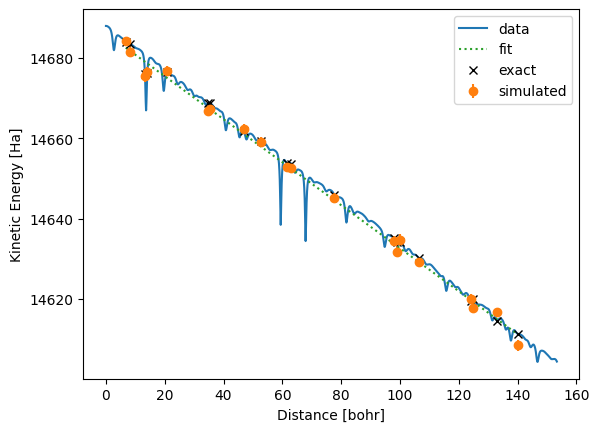

In [33]:
# look at the kinetic energy data
distance = time_au * velocity_time
plt.plot(distance, ke_time, label="data")
plt.errorbar(
    stopping_data.distance,
    stopping_data.kinetic,
    stopping_data.kinetic_err,
    fmt="o",
    label="simulated",
)
plt.plot(
    stopping_data.distance,
    stopping_data.linear_fit(stopping_data.distance),
    ls=":",
    label="fit",
)
plt.plot(
    stopping_data.distance,
    kproj_x_vals**2.0 / (2 * mass_proj),
    marker="x",
    label="exact",
    lw=0,
    color="black",
)
plt.legend()
plt.xlabel("Distance [bohr]")
plt.ylabel("Kinetic Energy [Ha]")
plt.plot()

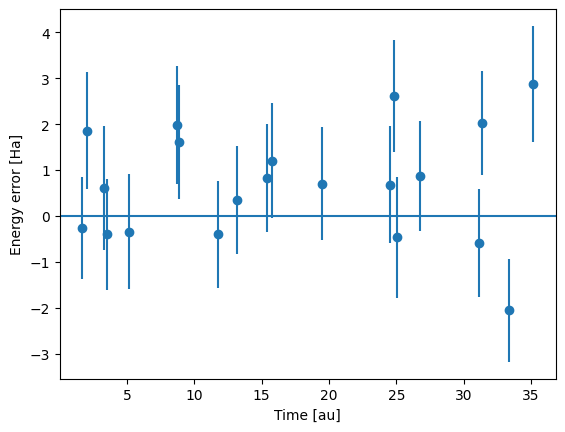

In [34]:
# look at expected vs simulated kinetic energy error
plt.errorbar(
    stopping_data.time_vals,
    np.sum(kproj_vals**2.0, axis=-1) / (2 * mass_proj) - stopping_data.kinetic,
    stopping_data.kinetic_err,
    fmt="o",
)
plt.xlabel("Time [au]")
plt.ylabel("Energy error [Ha]")
plt.axhline(0)

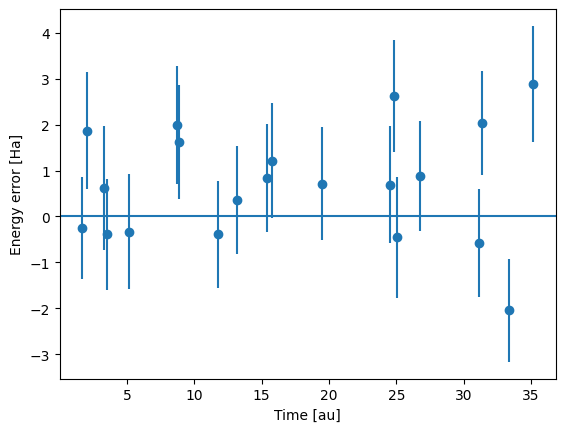

In [35]:
# include variance term in "exact projectile ke"
ke_exact = (
    np.sum(kproj_vals**2.0, axis=-1) + 3 * stopping_data.sigma_vals**2.0
) / (2 * mass_proj)
plt.errorbar(
    stopping_data.time_vals,
    ke_exact - stopping_data.kinetic,
    stopping_data.kinetic_err,
    fmt="o",
)
plt.xlabel("Time [au]")
plt.ylabel("Energy error [Ha]")
plt.axhline(0)

expected_stopping = -0.5321931772498634
value from file = 0.5388580705882354


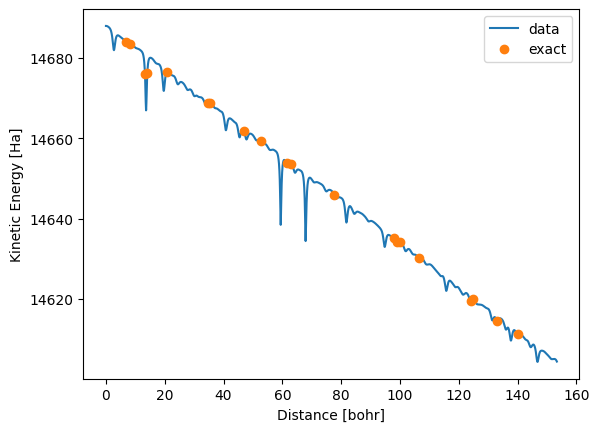

In [36]:
# Find "exact" stopping power from DFT data
distance = time_au * velocity_time
plt.plot(distance, ke_time, label="data")
plt.plot(
    stopping_data.distance,
    kproj_x_vals**2.0 / (2 * mass_proj),
    marker="o",
    label="exact",
    lw=0,
)
plt.legend()
plt.xlabel("Distance [bohr]")
plt.ylabel("Kinetic Energy [Ha]")
plt.plot()


def _fit_linear(x, a, b):
    return a * x + b


yvals = kproj_x_vals**2.0 / (2 * mass_proj)
popt, pcov = scipy.optimize.curve_fit(
    _fit_linear,
    stopping_data.distance,
    yvals,
)
expected_val = popt[0]
print(f"expected_stopping = {expected_val}")
print(f"value from file = {stopping_spl(4.0)}")

In [37]:
# Monitor convergence with sampling amount
results = []
num_samples = np.logspace(1, 5, 8)
for ns in num_samples:
    results.append(
        compute_stopping_power(
            ecut_ha,
            box_length,
            sigma_k,
            time_vals,
            kproj_vals,
            stopping_deriv,
            mass_proj,
            num_samples=int(ns),
        )
    )

Text(0, 0.5, 'Stopping Power [au]')

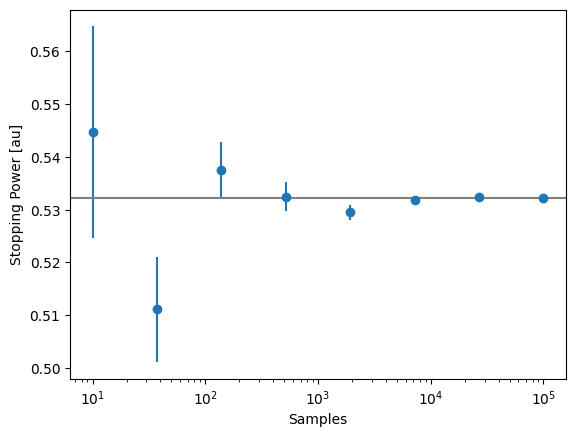

In [38]:
means = [r.stopping for r in results]
errs = [r.stopping_err for r in results]
plt.errorbar(num_samples, np.abs(means), yerr=errs, fmt="o")
plt.axhline(np.abs(expected_val), color="grey")
plt.xlabel("Samples")
plt.xscale("log")
plt.ylabel("Stopping Power [au]")

In [39]:
num_samples = 1_000
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import parse_stopping_data

for vel in velocity_au:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist", vel, mass_proj=mass_proj, num_points=20
    )
    stopping_deriv = np.abs(stopping_deriv_spl(vel))
    kproj_vals = np.array([np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample])
    stopping_data = compute_stopping_power(
        ecut_ha,
        box_length,
        sigma_k,
        dft_data.time_sub_sample,
        kproj_vals,
        stopping_deriv,
        mass_proj,
        num_samples=num_samples,
    )
    sim_res.append(stopping_data)
    yvals = dft_data.kproj_sub_sample**2.0 / (2 * mass_proj)
    popt, pcov = scipy.optimize.curve_fit(
        _fit_linear,
        stopping_data.distance,
        yvals,
    )
    expected_val = popt[0]
    act_res.append(abs(expected_val))

Text(0, 0.5, 'Stopping Power [au]')

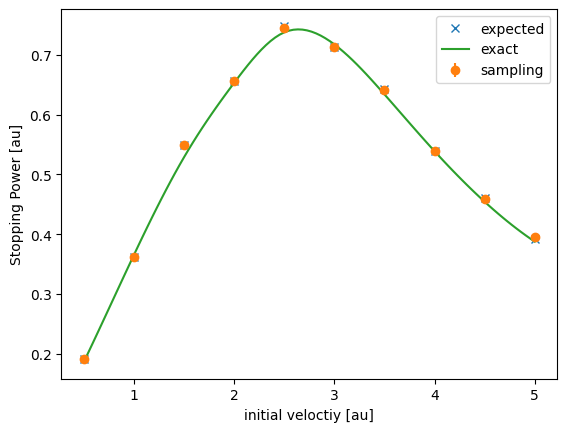

In [40]:
plt.plot(velocity_au, act_res, label="expected", lw=0, marker="x")
vals = [abs(s.stopping) for s in sim_res]
errs = [s.stopping_err for s in sim_res]
plt.errorbar(velocity_au, vals, yerr=errs, fmt="o", label="sampling")
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
plt.plot(xs, stopping_spl(xs), label="exact")
plt.legend()
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power [au]")

Text(0, 0.5, 'Stopping Power error [au]')

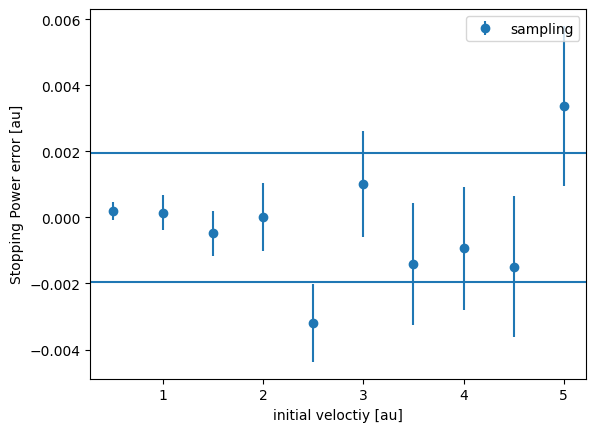

In [41]:
vals = [abs(s.stopping) for s in sim_res]
errs = [s.stopping_err for s in sim_res]
plt.errorbar(velocity_au, np.array(vals) - np.array(act_res), yerr=errs, fmt="o", label="sampling")
# plt.plot(velocity_au, act_res, label="expected", lw=0, marker="x")
plt.legend()
from ase.units import Hartree, Bohr
stopping_err = 0.1 # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
plt.axhline(stopping_err_au)
plt.axhline(-stopping_err_au)
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power error [au]")

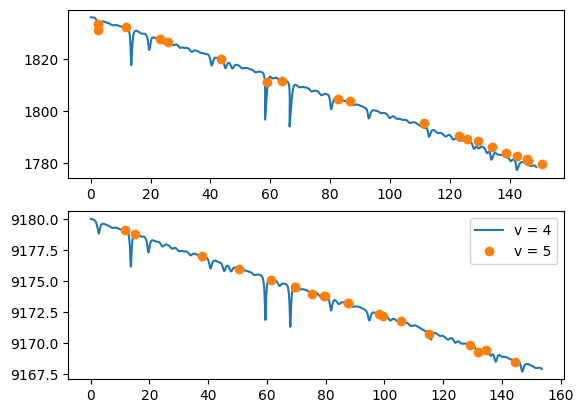

In [42]:
from mec_sandia.stopping_power import parse_stopping_data
data_1 = parse_stopping_data(
    f"AndrewsFirstGaussian/{1.0}_work_vs_dist", 1.0
)
data_5 = parse_stopping_data(
    f"AndrewsFirstGaussian/{5.0}_work_vs_dist", 5.0 
)
fig, ax = plt.subplots(2,1)
ax[0].plot(data_1.distance, data_1.kproj, label="v = 1")
ax[0].plot(data_1.time_sub_sample, data_1.kproj_sub_sample, label="v = 1", marker="o", lw=0)
ax[1].plot(data_5.distance, data_5.kproj, label="v = 4")
ax[1].plot(5*data_5.time_sub_sample, data_5.kproj_sub_sample, label="v = 5", marker="o", lw=0)
plt.legend()

## Check minimum number of samples for given error thresholds and sigma

Text(0, 0.5, 'Stopping Power error [au]')

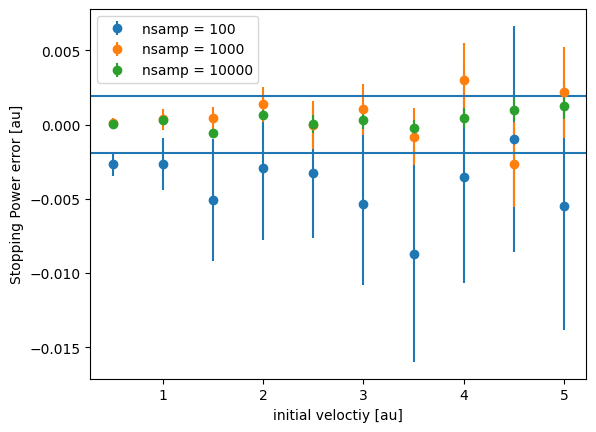

In [43]:
sim_res = []
act_res = []
qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units

from mec_sandia.stopping_power import parse_stopping_data
from ase.units import Bohr, Hartree

stopping_err = 0.1 # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 10

for num_samples in [100, 1_000, 10_000]:
    sim_res = []
    act_res = []
    for vel in velocity_au:
        dft_data = parse_stopping_data(
            f"AndrewsFirstGaussian/{vel}_work_vs_dist", vel, mass_proj=mass_proj, num_points=20
        )
        stopping_deriv = np.abs(stopping_deriv_spl(vel))
        kproj_vals = np.array([np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample])
        stopping_data = compute_stopping_power(
            ecut_ha,
            box_length,
            sigma_k,
            dft_data.time_sub_sample,
            kproj_vals,
            stopping_deriv,
            mass_proj,
            num_samples=num_samples,
        )
        sim_res.append(stopping_data)
        yvals = dft_data.kproj_sub_sample**2.0 / (2 * mass_proj)
        popt, pcov = scipy.optimize.curve_fit(
            _fit_linear,
            stopping_data.distance,
            yvals,
        )
        expected_val = popt[0]
        act_res.append(abs(expected_val))
    vals = [abs(s.stopping) for s in sim_res]
    errs = [s.stopping_err for s in sim_res]
    plt.errorbar(velocity_au, np.array(vals) - np.array(act_res), yerr=errs, fmt="o", label=f"nsamp = {num_samples}")
    plt.legend()
plt.axhline(stopping_err_au)
plt.axhline(-stopping_err_au)
plt.xlabel("initial veloctiy [au]")
plt.ylabel("Stopping Power error [au]")

## Check Convergence

In [44]:
# Get DFT data
vel = 0.5
qData1 = np.loadtxt(f"AndrewsFirstGaussian/{vel}_work_vs_dist")
position_au = qData1[:, 0] / (
    0.529
)  # divide the positions (angstroms) by the number of angstroms per atomic unit
time_au = (
    position_au / vel
)  # divide the positions in atomic units by the velocity in atomic units to get the time in atomic units
work_au = (
    qData1[:, 1] / 27.2
)  # divide the work in eV by the number of eV per atomic unit of energy

0.0019446903957408628


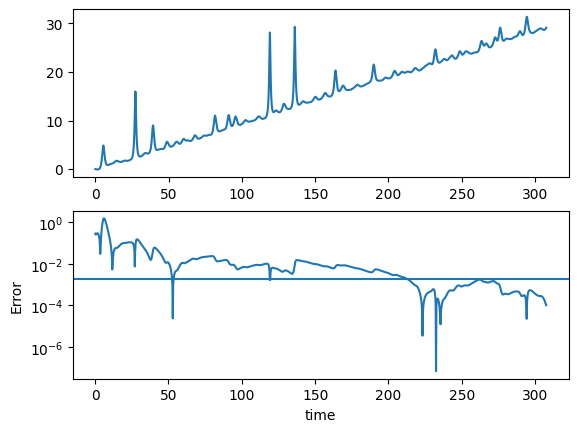

In [45]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(time_au, work_au)
times = []
results = []
stopping_spl(vel)
ke_time = 0.5 * mass_proj * (v_proj**2) - work_au
velocity_time = np.sqrt(2.0 / mass_proj * ke_time)  # 1/2 mv^2 = KE, so sqrt(2/m*KE)=v
for time_slice in range(10, len(time_au), 20):
    popt, pcov = scipy.optimize.curve_fit(
        # _fit_linear, velocity_time[:time_slice]*time_au[:time_slice], work_au[:time_slice],
        _fit_linear,
        vel * time_au[:time_slice],
        work_au[:time_slice],
    )
    times.append(time_au[:time_slice][-1])
    results.append(popt[0])
from ase.units import Hartree, Bohr
stopping_err = 0.1 # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
print(stopping_err_au)
ax[1].plot(times, abs(stopping_spl(vel) - np.array(results)))
ax[1].axhline(stopping_err_au)
ax[1].set_xlabel("time")
ax[1].set_ylabel("Error")
ax[1].set_yscale("log")

# Cross-check with Electrons

Volume = 255.27133939199965 A^3
rs = 0.9289611708818379 bohr
box_length = 11.987617756468008 bohr
Generating stopping data from scratch.
vel = 0.5, ns = 1000
Generating stopping data from scratch.
vel = 1.0, ns = 1000
Generating stopping data from scratch.
vel = 1.5, ns = 1000
Generating stopping data from scratch.
vel = 2.0, ns = 1000
Generating stopping data from scratch.
vel = 2.5, ns = 1000
Generating stopping data from scratch.
vel = 3.0, ns = 1000
Generating stopping data from scratch.
vel = 3.5, ns = 1000
Generating stopping data from scratch.
vel = 4.0, ns = 1000
Generating stopping data from scratch.
vel = 4.5, ns = 1000
Generating stopping data from scratch.
vel = 5.0, ns = 1000


<ErrorbarContainer object of 3 artists>

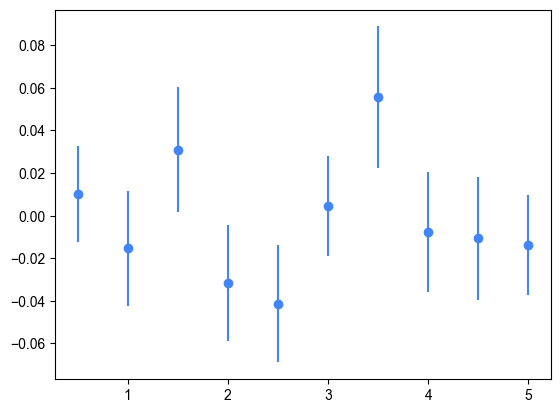

In [16]:
from ase.units import Bohr, Hartree
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

from mec_sandia.stopping_power import (
    compute_stopping_power_electrons,
    parse_stopping_data,
)
from mec_sandia.vasp_utils import compute_wigner_seitz_radius
from mec_sandia.vasp_utils import read_kohn_sham_data
from mec_sandia.vasp_utils import read_vasp

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "arial"

colors = ["#4285f4", "#ea4335", "#fbbc04", "#34a853"]


qData2 = np.loadtxt("AndrewsFirstGaussian/C_10gpcc_1eV_stopping_config1.txt")
velocity_au = qData2[:, 0]  # the velocities are already given in atomic units
stopping_au = qData2[:, 1] * (
    Bohr / Hartree
)  # the stopping powers are given in eV/A, so we multiply by the number of A/bohr and divide by the number of eV/Ha

stopping_spl = CubicSpline(velocity_au, stopping_au)
xs = np.linspace(velocity_au[0], velocity_au[-1], 100)
stopping_deriv_spl = stopping_spl.derivative(1)

stopping_err = 0.1  # eV/A
stopping_err_au = stopping_err * Bohr / Hartree
sigma_k = 10
mass_proj = 1836

ase_cell = read_vasp(f"../vasp_data/C_POSCAR")
# Next we can get some system paramters
volume_ang = ase_cell.get_volume()
print("Volume = {} A^3".format(volume_ang))

# To compute rs parameter we need volume in Bohr
from ase.units import Bohr

volume_bohr = volume_ang / Bohr**3
# and the number of valence electrons
num_carbon = len(np.where(ase_cell.get_atomic_numbers() == 6)[0])
# There is 1 hydrogen atom in the cell
num_elec = 1 + num_carbon * 4

# Get the Wigner-Seitz radius
rs = compute_wigner_seitz_radius(volume_bohr, num_elec)
print("rs = {} bohr".format(rs))

ecut_ha = 2000
box_length = volume_bohr ** (1.0 / 3.0)
print("box_length = {} bohr".format(box_length))

# Thermal data
eigs_1ev, occs_1ev = read_kohn_sham_data("../vasp_data/C_1eV_EIGENVAL")
np.random.seed(7)

sim_res = []
errs = []

num_samples = 1_000

act_res = []
errs = []
for vel in velocity_au:
    dft_data = parse_stopping_data(
        f"AndrewsFirstGaussian/{vel}_work_vs_dist",
        vel,
        mass_proj=mass_proj,
        num_points=20,
    )
    stopping_deriv = np.abs(stopping_deriv_spl(vel))
    kproj_vals = np.array(
        [np.array([kx, 0, 0]) for kx in dft_data.kproj_sub_sample]
    )
    print("Generating stopping data from scratch.")
    print(f"vel = {vel}, ns = {num_samples}")
    stopping_data = compute_stopping_power_electrons(
        eigs_1ev,
        occs_1ev,
        sigma_k,
        dft_data.time_sub_sample,
        kproj_vals,
        stopping_deriv,
        mass_proj,
        num_samples=num_samples,
    )
    sim_res.append(stopping_data)
    act_res.append(abs(stopping_data.stopping_expected))
    vals = [abs(s.stopping) for s in sim_res]
    errs = [s.stopping_err for s in sim_res]
#plt.errorbar(stopping_data.time_vals, stopping_data.kinetic, yerr=stopping_data.kinetic_err, fmt='o')
plt.errorbar(
    velocity_au,
    np.array(vals) - np.array(act_res),
    yerr=errs,
    fmt="o",
    color=colors[0],
    label=r"$N_s$ = {:d}".format(num_samples),
)
